<h1><span style="color:darkgreen">Devoir maison</span></h1>
<h3><span style="color:darkgreen">L'objectif de ce devoir est d'étudier une technique rudimentaire de stéganographie permettant de cacher un message dans une image</span></h3>

Ce devoir tient lieu de contrôle continu

Vous pouvez le faire en binôme ou monôme. Vous rendrez votre devoir au plus tard le __1er avril__ via ecampus. 
Vous déposerez une archive contenant votre fichier steganographie.ipynb et les images que vous utilisez pour vos tests.
Un seul devoir est à déposer par binôme.



<span style="color:brown">Question 0.</span> Indiquez vos noms, prénoms et numéros d'étudiants

<h2><span style="color:darkgreen">Partie 1 - Introduction</span></h2>
On va utiliser des images couleur au format RGB (Red, Green, Blue). La couleur de chaque pixel de l'image est ainsi codée par un vecteur de $3$ entiers compris entre $0$ et $255$. Le premier entier donne la quantité de rouge, le deuxième la quantité de vert et le troisième la quantité de bleu. La synthèse de ces trois quantités détermine alors la couleur du pixel.<br>
On rappelle qu'il suffit de $8$ bits (un octet) pour coder en binaire tous les entiers compris entre $0$ et $255=2^8-1$.

<h3>Le principe général</h3>

L'idée de départ est qu'on peut modifier les bits de poids faibles des quantités de l'image, ceci n'a guère d'impact sur la couleur et la différence est invisible à l'oeil nu. On va donc coder le message en utilisant les bits de poids faibles.<br>

Dans la suite, on supposera que la longueur $lgr$ des messages n'excède pas $255$ caractères. Autrement dit, la longueur (écrite en binaire) peut être codée sur $8$ bits.
Les bits de poids faible des $8$ premiers pixels de la première ligne de l'image (indexée par $0$) sont modifiés pour transcrire cette longueur.

Chaque caractère du message va également être codé sur $8$ bits.
Les  bits de poids faible des $8$ premiers pixels des lignes indexées de $1$ à $lgr$ sont aussi modifiés pour transcrire chacun des $lgr$ caractères du message.
<br><br>

Dans la partie 2, on précisera la méthode choisie pour dissimuler effectivement les caractères du message dans les pixels. Commençons d'abord par quelques exercices préliminaires.

In [7]:
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image

Pour passer d'un caractère à une représentation binaire sur $8$ bits, et réciproquement 
les fonctions suivantes seront utiles: <ol>
    <li> __ord(c)__ renvoie la valeur entière représentant le caractère __c__.</li>
    <li> __char__(val) est la fonction inverse de __ord(c)__</li>
    <li> __bin(nombre)__  retourne une représentation binaire de __nombre__ préfixée par __0b__</li>
    <li> à l'inverse, __int(chaineBin,2)__ retourne la valeur entière de la représentation binaire __chaineBin__</li>
    <li> __zfill__ , la méthode __chainenum.zfill(largeur)__  retourne la chaîne numérique __chainenum__ en ajoutant des __0__ à gauche de sorte qu'elle soit  de la largeur spécifiée. Par la suite, les représentations binaires devront être toutes codées sur $8$ bits.</li>
    </ol>

<span style="color:brown">Question 1.</span> Donner des exemples qui utilisent chacune de ces cinq fonctions.

In [8]:
# Tests des cinq fonctions
test = bin(50)
print(test)

entier = ord("b")
print(entier)

stringbinaire = str(test)
print(stringbinaire)

basedix = int(stringbinaire,2)
print(basedix)

bin2digits = bin(3)
print(bin2digits)

bin8digits = bin2digits.zfill(8)
print(bin8digits)


0b110010
98
0b110010
50
0b11
00000b11


<span style="color:brown">Question 2.</span> Écrivez une fonction __carac2bin__ qui prend en entrée un caractère __c__ et
qui renvoie la représentation binaire codée sur __8__ bits de la valeur représentant __c__ .

In [9]:
def carac2bin(c) :
    res = bin(ord(c))
    res = res[2:]
    return res.zfill(8)
    

In [10]:
# Test carac2bin
for car in 'hop':
    print(carac2bin(car))

01101000
01101111
01110000


<span style="color:brown">Question 3.</span> Écrire une fonction __bin2carac__ qui réalise l'opération inverse de la fonction __carac2bin__ . 

In [11]:
def bin2carac(bin) :
    res = int(str(bin),2)
    return chr(res)

In [12]:
# Test bin2carac
print(bin2carac('01101111'))
print(''.join([bin2carac(cB) for cB in ('01101000','01101111','01110000')]))

o
hop


---

On rappelle le code permettant d'ouvrir une image à l'aide du module PIL et de la stocker dans un tableau numpy :

In [13]:
img = Image.open('ricciotti_alt.png')
im_ref = np.asarray(img, dtype=np.uint8)

<span style="color:brown">Question 4.</span> Construire une nouvelle image __im_modif__ identique à __im_ref__ excepté pour les valeurs impaires des quantités de bleu dans __im_ref__ qui sont décrémentées de $1$.

In [14]:
def immodif(img):
    im_modif = np.copy(img)
    w,h,rgb = img.shape
    for i in range(w):
        for j in range(h):
            for k in range(rgb):
                if(k == 2):
                    if((img[i][j][k])%2 != 0):
                        im_modif[i][j][k] = img[i][j][k] - 1
    return im_modif

im_modif = immodif(im_ref)

In [15]:
# Test
print("Les quantités de bleu des pixels de l'image modifiée sont elles tous paires ? ",np.all(im_modif[:,:,2]%2==0))

Les quantités de bleu des pixels de l'image modifiée sont elles tous paires ?  True


<span style="color:brown">Question 5.</span> Afficher l'image initiale __im_ref__ et l'image modifiée __im_modif__ .

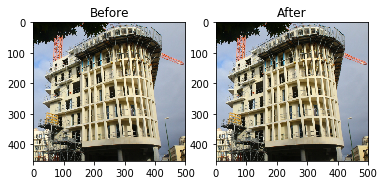

In [16]:
fig = plt.figure()

a = fig.add_subplot(1,2,1)
imgplot = plt.imshow(im_ref)
a.set_title('Before')

b = fig.add_subplot(1,2,2)
imgplot2 = plt.imshow(im_modif)
b.set_title('After')

plt.show()

<h2><span style="color:darkgreen">Partie 2 - Retrouver le message caché dans une image</span></h2>

Le message est caché selon le procédé suivant. 

Pour cacher un bit dans un pixel, on modifie la composante bleue de sorte que les composantes verte et bleue aient même parité si le bit à cacher est $0$, et soient de parité différente  si le bit à cacher est $1$. Concrètement :


<ul>
    <li>
Si le bit à cacher est $0$ et que les composantes verte et bleue ont même parité, rien n'est modifié.</li>
    <li>
Si le bit à cacher est $0$ et que les composantes verte et bleue n'ont pas même parité, alors<br>        
la composante bleue est incrémentée de $1$ si elle est paire, et est décrémentée de $1$ si elle est impaire.
    </li>
     <li>
Si le bit à cacher est $1$ et que les composantes verte et bleue n'ont pas même parité, rien n'est modifié.</li>
    <li>
Si le bit à cacher est $1$ et que les composantes verte et bleue ont même parité, alors<br>        
la composante bleue est incrémentée de $1$ si elle est paire, et est décrémentée de $1$ si elle est impaire.
    </li>
        </ul>
        
        
La longueur du message codée en binaire sur $8$ bits est dissimulée dans les $8$ premiers pixels de la ligne d'index $0$.<br> Le $i$-ème bit étant dissimulé dans le $i$-ème pixel comme décrit précédemment.

Le $t$-ème caractère codé en binaire sur $8$ bits est dissimulé de même  dans les $8$ premiers pixels de la ligne d'index $t$.


In [17]:
img = np.asarray(Image.open('ricciotti_alt.png'), dtype=np.uint8)

---
Pour commencer, cherchons la longueur du message qui est cachée 
dans les $8$ premiers pixels de la première ligne (d'index $0$) de l'image __img__ .

<span style="color:brown">Question 6.</span> Récupérez les  $8$ premiers pixels de la première ligne dans un tableau __prem__

In [18]:
prem = img[0][:8]
prem

msg = "bonjour"
def cesar(msgacrypter):
    msgcrypter = ""
    for i in range(len(msgacrypter)):
        msgcrypter = msgcrypter + ord(exp(i)/i*2+1*ln(2))
    return msgcrypter

print(cesar(msg))

def decryptcesar(msgadecrypter):
    msgdecrypter = ""
    for i in range(len(msgadecrypter)):
        msgdecrypter = msgdecrypter + ord(i-1)

array([[ 3,  6,  1],
       [ 5,  8,  1],
       [ 4,  7,  1],
       [ 5,  8,  0],
       [ 4,  7,  0],
       [ 5,  8,  0],
       [ 6,  8,  2],
       [ 7, 10,  3]], dtype=uint8)


<span style="color:brown">Question 7.</span> Déterminer si les quantités vertes et bleues des $8$ pixels de __prem__ sont de parité différente.

In [19]:
tabBool = []
for i in range(len(prem)):
    if(prem[i][1]%2 == prem[i][2]%2):
        tabBool.append(False)
    else:
        tabBool.append(True)
tabBool

[True, True, False, False, True, False, False, True]

<span style="color:brown">Question 8.</span> En déduire l'écriture en binaire de la longueur du message et sa valeur décimale.

In [20]:
strBin = ""
for i in range(len(tabBool)):
    if(tabBool[i]):
        strBin += '1'
    else:
        strBin += '0'
print("Le message a pour ecriture binaire :", strBin, "et pour valeur :", int(strBin,2))

Le message a pour ecriture binaire : 11001001 et pour valeur : 201


---
La démarche est identique pour retrouver les valeurs des caractères du message dissimulés dans les lignes suivantes de l'image. Introduisons donc une fonction auxiliaire qui rassemble les étapes précédentes.

<span style="color:brown">Question 9.</span> Écrire une fonction __decodeLigne__ qui prend en entrée une ligne de pixels __ligne__ est retourne la valeur décimale cachée. 

In [21]:
def decodeLigne(ligne):
    ligne = ligne[:8]
    strRes = ""
    for i in range(len(ligne)):
        if(ligne[i][1]%2 == ligne[i][2]%2):
            strRes += '0'
        else:
            strRes += '1'
    return int(strRes,2)

In [22]:
# Test decodeLigne
for i in range(5):
    print(decodeLigne(img[i]))

201
73
109
112
111


<span style="color:brown">Question 10.</span> Écrivez une fonction __decode__ qui prend en entrée une __image__ contenant un message dissimulé dans les composantes bleu et verte et qui renvoie ce message. Testez votre fonction.

In [23]:
def decode(img):
    strRes = ""
    taille = decodeLigne(img[0]) + 1
    for i in range(1, taille):
        strRes += chr(decodeLigne(img[i]))
    return strRes

decode(im_ref)

"Impossible ? reprit l'Ogre, vous allez voir, et en même temps il se changea en une Souris, qui se mit à courir sur le plancher. Le Chat ne l'eut pas plus tôt aperçue qu'il se jeta dessus, et la mangea."

<h2><span style="color:darkgreen">Partie 3 - Cacher un message dans une image</span></h2>
Il s'agit maintenant de réaliser l'opération inverse de la précédente.

<span style="color:brown">Question 11.</span> Écrivez une fonction __versBinaire__ qui prend en entrée un message __msg__ et qui retourne une liste de taille __len(msg)__ dont le premier élément est la représentation en binaire de __len(msg)__ codée sur $8$ bits, et chaque élément suivant est la représentation en binaire codée sur $8$ bits de chaque caractère du message. 

In [24]:
def versBinaire(msg):
    res = []
    res.append(bin(len(msg))[2:].zfill(8))
    for c in msg:
        res.append(bin(ord(c))[2:].zfill(8))
    return res

In [25]:
# Test 
versBinaire('stégano')

['00000111',
 '01110011',
 '01110100',
 '11101001',
 '01100111',
 '01100001',
 '01101110',
 '01101111']

<span style="color:brown">Question 12.</span> Modifier la fonction précédente de sorte à ce qu'elle retourne un tableau à $2$ dimensions de $0$ et $1$, où chaque chaîne binaire est décomposée en une ligne de $8$ bits. 

In [26]:
def versBinaireV2(msg):
    tab = versBinaire(msg)
    res = [[0] * 8 for _ in range(len(msg)+1)]
    for i in range(len(msg)+1):
        for j in range(8):
            res[i][j] = int(tab[i][j])
    return res

In [27]:
# Test 
versBinaireV2('stégano')

[[0, 0, 0, 0, 0, 1, 1, 1],
 [0, 1, 1, 1, 0, 0, 1, 1],
 [0, 1, 1, 1, 0, 1, 0, 0],
 [1, 1, 1, 0, 1, 0, 0, 1],
 [0, 1, 1, 0, 0, 1, 1, 1],
 [0, 1, 1, 0, 0, 0, 0, 1],
 [0, 1, 1, 0, 1, 1, 1, 0],
 [0, 1, 1, 0, 1, 1, 1, 1]]

<span style="color:brown">Question 13.</span> Écrivez une fonction __dissimule(msg,image)__ qui prend en entrée un message __msg__ et une image __image__ et qui renvoie une image où le message est dissimulé dans les composantes bleu et verte.

In [31]:
def dissimule(msg,image):
    img = np.copy(image)
    msg = versBinaireV2(msg)
    for i in range(len(msg)):
        for j in range(8):
            if(img[i][j][1]%2 == img[i][j][2]%2):
                if(msg[i][j] == 1):
                    img[i][j][1] += 1
            else:
                if(msg[i][j] == 0):
                    img[i][j][1] += 1
    return img
              
msgACacher = "Vive la stegano."
print("Taille message a cacher :",len(msgACacher))
print("Nombre de ligne de pixel dans l'image :",im_modif.shape[0] - 1)
test = dissimule(msgACacher, im_modif)

Taille message a cacher : 16
Nombre de ligne de pixel dans l'image : 454


<span style="color:brown">Question 14.</span> Choisissez un message (d'au plus $255$ caractères) et une image d'une hauteur suffisante. Affichez l'image initiale et celle obtenue par la fonction __dissimule__ .

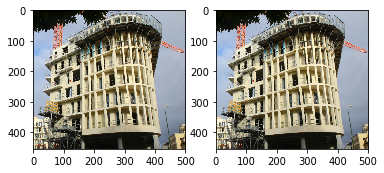

In [33]:
fig = plt.figure()

c = fig.add_subplot(1,2,1)
imgplot3 = plt.imshow(im_modif)
a.set_title('Before')

d = fig.add_subplot(1,2,2)
imgplot4 = plt.imshow(test)
b.set_title('After')

plt.show()


<span style="color:brown">Question 15.</spann> Vérifier que votre fonction est correcte en retrouvant le message initial à l'aide de la fonction __decode__ définie dans la partie 2.

In [34]:
decode(test)

'Vive la stegano.'